# Randomized benchmarking (1 qubit)

In [1]:
import random
import datetime
from typing import List
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from braket.circuits import Circuit, Gate, Instruction, Noise
from braket.devices import LocalSimulator
from scipy.optimize import curve_fit

from rb_utils import rb_fit_fun_1q
from rb_utils import randomizing_benchmarking_simulator_1q, randomizing_benchmarking_hardware_1q

## local simulator

In [ ]:
device = LocalSimulator("braket_dm")

depth_list = range(1, 50, 5) 
rb_data_sim = randomizing_benchmarking_simulator_1q(device, depth_list=depth_list, repeats=15, shots=100)
# print(rb_data)

rb_line_sim = rb_data_sim.groupby("depth").mean()["prob"]
sigma_sim = rb_data_sim.groupby("depth")["prob"].std()

In [ ]:
fit_guess = [0.95, 0.99]
params, pcov = curve_fit(rb_fit_fun_1q, depth_list, rb_line_sim.values, sigma=sigma_sim, 
                         p0=fit_guess, bounds=([0, 0], [1, 1]))
alpha = params[1]  # exponent
params_err = np.sqrt(np.diag(pcov))
alpha_err = params_err[1]
gate_noise = 1-alpha
readout_noise = 0.5-params[0]

print("Gate fidelity: ", alpha)
print("Gate error: ", gate_noise/2)
print("Gate error uncertainty: ", np.round(100*alpha_err/gate_noise, 4), "%")
print("Readout error: ", readout_noise)

plt.plot(depth_list, rb_fit_fun_1q(depth_list, *params), "g", label="fit: a=%5.3f, b=%5.3f" % tuple(params))
plt.plot(depth_list, rb_line_sim.values, "ro", label="RB data")
plt.legend()
plt.show()

## Hardware

In [18]:
from braket.aws import AwsDevice
now = datetime.datetime.now().strftime('%y%m%d%H%M%S')
my_bucket = "amazon-braket-hardware-validation" # the name of the bucket
my_prefix = "rigetti-M1-"+now # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
# device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-11")

depth_list = range(1,300,20)
rb_data_hw = randomizing_benchmarking_hardware_1q(device, s3_folder=s3_folder, depth_list=depth_list, 
                                                    repeats=10, shots=100)
# print(rb_data)

In [19]:
fname = os.path.join('results',my_prefix)
with open(fname, 'wb') as f:
    pickle.dump(rb_data_hw, f)
    pickle.dump(depth_list, f)

Gate fidelity:  0.9981798584824049
Gate error:  0.0009100707587975654
Gate error uncertainty:  6.1205 %
Readout error:  0.02413235151421711


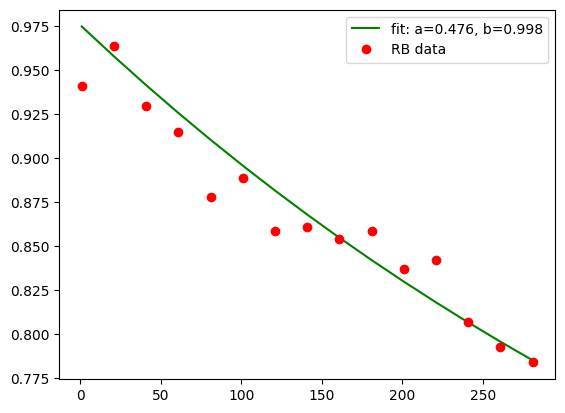

In [21]:
rb_line_hw = rb_data_hw.groupby("depth").mean()["prob"]
sigma_hw = rb_data_hw.groupby("depth")["prob"].std()

fit_guess = [0.95, 0.99]
params, pcov = curve_fit(rb_fit_fun_1q, depth_list, rb_line_hw.values, sigma=sigma_hw, 
                         p0=fit_guess, bounds=([0, 0], [1, 1]))
alpha = params[1]  # exponent
params_err = np.sqrt(np.diag(pcov))
alpha_err = params_err[1]
gate_noise = 1-alpha
readout_noise = 0.5-params[0]

print("Gate fidelity: ", alpha)
print("Gate error: ", gate_noise/2)
print("Gate error uncertainty: ", np.round(100*alpha_err/gate_noise, 4), "%")
print("Readout error: ", readout_noise)

plt.plot(depth_list, rb_fit_fun_1q(depth_list, *params), "g", label="fit: a=%5.3f, b=%5.3f" % tuple(params))
plt.plot(depth_list, rb_line_hw.values, "ro", label="RB data")
plt.legend()
# plt.savefig(os.path.join('results',my_prefix+'_plot.png'))
plt.show()

## Load result

In [9]:
# import pickle
# with open('results/rigetti-M1-220216161123', 'rb') as f:
#     rb_data_hw = pickle.load(f)
#     depth_list = pickle.load(f)